In [1]:
import sys
import numpy as np
import math
import ceo
%pylab inline
%run GMT_DOS_SAO.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
nPx = N_PX_LENLSET*N_LENSLET+1
print "pupil sampling:      %d pixel"%nPx
detectorRes = 2.0*N_PX_LENLSET*N_LENSLET/2.0
print "detector resolution: %d pixel"%detectorRes
zenith_angle  = np.ones((1,N_GS))*zenith_distance_arcmin*ceo.constants.ARCMIN2RAD # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
gs    = ceo.Source(AGWS_photometric_band,
                   zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                   rays_box_size=entrance_pupil_size_meter,
                   rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(N_LENSLET, N_PX_LENLSET, lenslet_pitch_meter, 
                        N_PX_IMAGE=2*N_PX_LENLSET,BIN_IMAGE=2,N_GS=N_GS)
gmt = ceo.GMT_MX(entrance_pupil_size_meter,nPx,M1_radial_order=M1_zernike_radial_order)

pupil sampling:      469 pixel
detector resolution: 468 pixel


In [3]:
gs.wavelength*ceo.constants.RAD2ARCSEC/2

0.06600473759792895

In [4]:
from scipy.optimize import brentq
def ee80(_psf_,_px_scale_):
    n,m = _psf_.shape
    u = np.linspace(-1,1,n)*(n/2)
    v = np.linspace(-1,1,m)*(m/2)
    x,y = np.meshgrid(u,v)
    def ee80_fun(ee_Delta):
        _ee_Delta_ = (ee_Delta-1)/2
        gate = np.logical_and(np.abs(x)<=_ee_Delta_,np.abs(y)<=_ee_Delta_)
        return np.sum(psf*gate)/(src.nPhoton*368) - 0.8
    try:
        q = brentq(ee80_fun,1,81)*_px_scale_*ceo.constants.RAD2MAS
    except ValueError:
        q = np.float('inf')
    return q

pixel size: 1.27mas


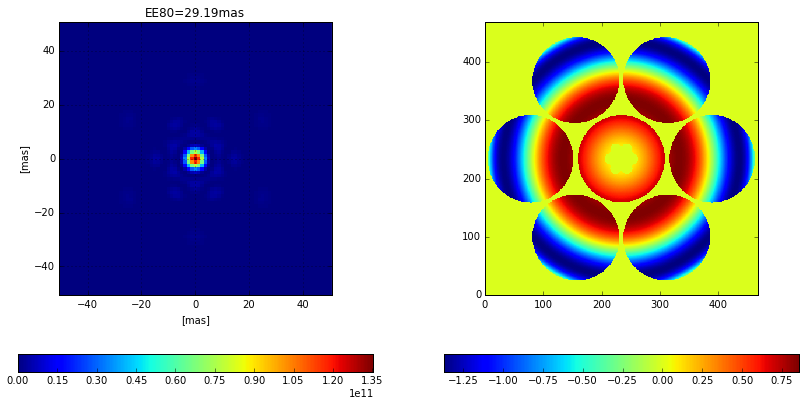

In [5]:
src = ceo.Source(S_photometric_band,
                 rays_box_size=entrance_pupil_size_meter,
                 rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt.reset()
gmt.propagate(src)
imgr = ceo.Imaging(1, nPx-1,DFT_osf=2*nyquist_oversampling_factor,
                   N_PX_IMAGE=detector_resolution,N_SOURCE=src.N_SRC)
imgr.propagate(src)
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
psf = imgr.frame.host()
px_scale = src.wavelength/(entrance_pupil_size_meter*4)
h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ee80_0 = ee80(psf,px_scale)
ax1.set_title("EE80=%.2fmas"%ee80_0)
colorbar(h1,ax=ax1,orientation='horizontal')
h2 = ax2.imshow(src.wavefront.phase.host(shape=(nPx*src.N_SRC,nPx),units='nm').T,interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')
print "pixel size: %.2fmas"%(px_scale*ceo.constants.RAD2MAS)

# Calibrations
## Wavefront sensors

[ 1277.90515137  1278.50878906  1278.47766113]


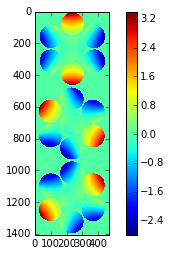

In [6]:
#gmt.M1.update(origin=[0e-6,0.0,0.0],idx=1)
#gs.reset()
gmt.reset()
gs.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
imshow(ps0,interpolation='None')
colorbar()
print gs.wavefront.rms()*1e9
wfs.calibrate(gs,0.8)

In [7]:
print wfs.frame.shape
print "Pixel size: %.3farcsec"%(wfs.pixel_scale_arcsec)
print "Field of view: %.3farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/2)

(1404, 468)
Pixel size: 0.132arcsec
Field of view: 2.376arcsec


12000.4795761
12000.4795761
331775.553307
399983.392063


<matplotlib.colorbar.Colorbar instance at 0x2b2bea293290>

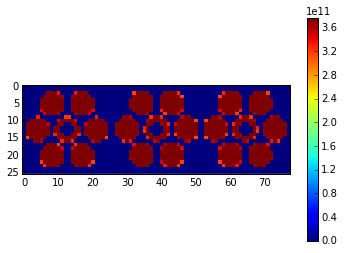

In [8]:
gs.magnitude = 0
print src.nPhoton*1e-9*368*3
print gs.nPhoton*1e-9*368
wfs.reset()
#wfs.analyze(gs)
wfs.propagate(gs)
wfs.readOut(30,0)
wfs.process()
imshow(wfs.flux.host().T,interpolation='none')
print wfs.flux.host().sum()*1e-9
print wfs.frame.host().sum()*1e-9
colorbar()

### Segment tip-tilt sensor

In [9]:
sts = ceo.SegmentTipTiltSensor()
gs.reset()
gmt.reset()
gmt.propagate(gs)
a230 = sts.tiptilt(gs)

## M2 tip-tilt

In [ ]:
D2tt = gmt.calibrate(wfs,gs,mirror="M2",mode="segment tip-tilt",stroke=200*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D2tt)
colorbar(h)
grid()
print "M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D2tt)

## M2 x,y,z translations with M2 segment tip-til removed

In [ ]:
mic2m = 1e-6
def M2_xyz(xyz,segId):
    gmt.reset()
    gmt.M2.update(origin=xyz,idx=segId)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [ ]:
def M2_seg_TT(origin=[0,0,0],originId=0):
    M = np.linalg.pinv(D2tt)
    M2_R = np.zeros((14,1))
    for kStep in range(4):
        M2_R += np.dot(M,wfs.valid_slopes.host().T)
    #    print M2_R/mas2rad
    #    print M2_R.shape
        for k in range(7):
            R = [-M2_R[2*k,0],-M2_R[2*k+1,0],0]
            if originId==(k+1):
                gmt.M2.update(origin=origin,euler_angles=R,idx=k+1)
            else:
                gmt.M2.update(euler_angles=R,idx=k+1)
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
#    imshow(1e3*wfs.c.host(shape=(nLenslet*2,nLenslet),units='arcsec').T,interpolation='none')
#    colorbar()
    return wfs.valid_slopes.host().ravel()

In [ ]:
stroke = 10
c_shape = (gs.N_SRC*N_LENSLET*2,N_LENSLET)
cp_x = cm_x = np.zeros(shape=c_shape)
cp_y = cm_y = np.zeros(shape=c_shape)
cp_z = cm_z = np.zeros(shape=c_shape)
ps_x = ps_y = ps_z = np.zeros(shape=gs.phase.shape)
D2xyz_2 = np.zeros((wfs.n_valid_slopes,3*7))
l = -1
sys.stdout.write("Segment #: ")
for k in range(1,8):
    sys.stdout.write("%d "%k)
    xyz = [stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_x = cp_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    
    ps_x = ps_x + mask*(ps - ps0)
    xyz = [-stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_x = cm_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,stroke*mic2m,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_y = cp_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_y = ps_y + mask*(ps - ps0)
    xyz = [0,-stroke*mic2m,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_y = cm_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,0,stroke*mic2m]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_z = cp_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_z = ps_z + mask*(ps - ps0)
    xyz = [0,0,-stroke*mic2m]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_z = cm_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

In [ ]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
#h2=ax2.imshow(np.concatenate((cp_z,cm_z),axis=1).T,interpolation='none')
h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

In [ ]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
h2=ax2.imshow(np.concatenate((cp_x,cm_x),axis=1).T,interpolation='none')
#h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

In [ ]:
fig, ax = subplots()
h = ax.pcolor(D2xyz_2)
colorbar(h)
axis("tight")
grid()
print "M2 x,y,x translation interaction matrix condition #: %6.2f"%np.linalg.cond(D2xyz_2)

In [ ]:
D =  ( D2xyz_2  )
U,S,V = np.linalg.svd(D)
semilogy(S,'.')
grid()

## M2 x,y,z translations with M2 segment tip-til removed

In [ ]:
def M1_tts(tt,segId):
    gmt.reset()
    gmt.M1.update(euler_angles=tt,idx=segId)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)

In [ ]:
stroke = 0.1*ceo.constants.ARCSEC2RAD
c_shape = (gs.N_SRC*N_LENSLET*2,N_LENSLET)
cp_x = cm_x = np.zeros(shape=c_shape)
cp_y = cm_y = np.zeros(shape=c_shape)
cp_z = cm_z = np.zeros(shape=c_shape)
ps_x = ps_y = ps_z = np.zeros(shape=gs.phase.shape)
D1stt_2 = np.zeros((wfs.n_valid_slopes,2*7))
l = -1
sys.stdout.write("Segment #: ")
for k in range(1,8):
    sys.stdout.write("%d "%k)
    tt = [stroke,0,0]
    M1_tts(tt,k)
    sp = M2_seg_TT(originId=k)
    cp_x = cp_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    
    ps_x = ps_x + mask*(ps - ps0)
    tt = [-stroke,0,0]
    M1_tts(tt,k)
    sm = M2_seg_TT(originId=k)
    cm_x = cm_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D1stt_2[:,l] = ((sp-sm)/2)/(stroke)    

    tt = [0,stroke,0]
    M1_tts(tt,k)
    sp = M2_seg_TT(originId=k)
    cp_y = cp_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_y = ps_y + mask*(ps - ps0)
    tt = [0,-stroke,0]
    M1_tts(tt,k)
    sm = M2_seg_TT(originId=k)
    cm_y = cm_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D1stt_2[:,l] = ((sp-sm)/2)/(stroke)    

In [ ]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
#h2=ax2.imshow(np.concatenate((cp_z,cm_z),axis=1).T,interpolation='none')
h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

In [ ]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
h2=ax2.imshow(np.concatenate((cp_x,cm_x),axis=1).T,interpolation='none')
#h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

In [ ]:
fig, ax = subplots()
h = ax.pcolor(D1stt_2)
colorbar(h)
axis("tight")
grid()
print "M2 x,y,x translation interaction matrix condition #: %6.2f"%np.linalg.cond(D1stt_2)

In [ ]:
U,S,V = np.linalg.svd( ( np.dot( pinv(D2xyz_2) , D1stt_2) ) , full_matrices=False) 
print U.shape
K = np.eye(U.shape[0]) - np.dot(U,U.T)
print K.shape
pcolor(K)
axis('tight')
colorbar()

In [ ]:
gmt.reset()
gmt.M1.update(euler_angles=[0.1*ceo.constants.ARCSEC2RAD,0,0],idx=1)
gs.reset()
gmt.propagate(gs)
imshow((gs.phase.host(units='micron')-ps0).T)
colorbar(orientation='horizontal')

In [ ]:
s = M2_seg_TT(originId=1)
imshow((gs.phase.host(units='micron')-ps0).T)
colorbar(orientation='horizontal')

In [ ]:
src.reset()
gmt.propagate(src)
imshow(src.phase.host(units='nm'))
colorbar()

In [ ]:
c2_a = np.dot( np.linalg.pinv(D2xyz_2) , wfs.valid_slopes.host().ravel())
print np.array_str(c2_a*1e9,precision=3,suppress_small=True)
c2_b = np.dot(K,c2_a)
print np.array_str(c2_b*1e9,precision=3,suppress_small=True)

In [ ]:
R = gmt.M2.motion_CS.euler_angles.tolist()
T = c2_a.reshape(7,-1).tolist()
for k in range(7):
    gmt.M2.update(origin=T[k],euler_angles=R[k],idx=k+1)
gs.reset()
gmt.propagate(gs)
imshow((gs.phase.host(units='micron')-ps0).T)
colorbar(orientation='horizontal')

In [ ]:
src.reset()
gmt.propagate(src)
imshow(src.phase.host(units='nm'))
colorbar()

In [ ]:
gmt.reset()
gmt.M2.update(origin=[0,1e-6,0],idx=1)
gs.reset()
gmt.propagate(gs)
imshow((gs.phase.host(units='micron')-ps0).T)
colorbar(orientation='horizontal')

In [ ]:
s = M2_seg_TT(origin=[0,1e-6,0],originId=1)
imshow((gs.phase.host(units='micron')-ps0).T)
colorbar(orientation='horizontal')

In [ ]:
c2 = np.dot( np.linalg.pinv(D2xyz_2) , wfs.valid_slopes.host().ravel())
print np.array_str(c2*1e9,precision=3,suppress_small=True)
c2 = np.dot(K,c2)
print np.array_str(c2*1e9,precision=3,suppress_small=True)

In [ ]:
D = np.concatenate((D1stt_2,D2xyz_2),axis=1)
print cond(D)

## M1 global tip-tilt with M2 segment tip-til removed

In [ ]:
mas2rad = 1e-3*math.pi/180/3600
def M1_global_TT(tip,tilt):
    gmt.reset()
    gmt.M1.global_tiptilt(tip,tilt)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [ ]:
amp = 50*ceo.constants.MAS2RAD
M1_global_TT(amp,0)
sp = M2_seg_TT()
fig, ax2 = subplots()
fig.set_size_inches(12,5)
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
M1_global_TT(-amp,0)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2 = np.zeros((wfs.n_valid_slopes,2))
D1gtt_2[:,0] = ((sp-sm)/2)/amp

In [ ]:
M1_global_TT(0,amp)
sp = M2_seg_TT()
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
fig, ax2 = subplots()
fig.set_size_inches(12,5)
M1_global_TT(0,-amp)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2[:,1] = ((sp-sm)/2)/amp

In [ ]:
pcolor(D1gtt_2)
grid()
xlabel('lenslets')
colorbar()
print "M1 global tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D1gtt_2)

## M1 bending modes

In [ ]:
mic2m = 1e-6
def M1_zern(zmode,zstroke,segId):
    gmt.reset()
    gmt.M1.zernike.a[segId,zmode] = zstroke
    gmt.M1.zernike.update()
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [ ]:
zStroke = 1e-7
l = -1
zmodes = [4,5]
zmodes.extend(range(6,10))
nZernCoefs = len(zmodes)
D1z_2 = np.zeros((wfs.n_valid_slopes,7*nZernCoefs))
ps_z = np.zeros(shape=gs.phase.shape)
for kSeg in range(7):
    sys.stdout.write("Segment #%d: "%kSeg)
    for kMode in zmodes:
        sys.stdout.write("%d "%(kMode+1))
        M1_zern(kMode,zStroke,kSeg)
        sp = M2_seg_TT()
        M1_zern(kMode,-zStroke,kSeg)
        sm = M2_seg_TT()
        l += 1
        D1z_2[:,l] = ((sp-sm)/2)/(zStroke)   
    #ps_z = ps_z + gs.phase.host(units='micron') - ps0
    sys.stdout.write("\n")

In [ ]:
fig, ax = subplots()
h = ax.pcolor(D1z_2)
colorbar(h)
grid()
print "Zernike modes interaction matrix condition #: %6.2f"%np.linalg.cond(D1z_2)

In [ ]:
D2tt7 = gmt.calibrate(sts,gs,mirror='M2',mode='geometric segment tip-tilt',
                 stroke=1*ceo.constants.ARCSEC2RAD)
pcolor(D2tt7)
colorbar()

In [2]:
import scipy.io as io
data = {}
data['D1z_2']=D1z_2
data['D1gtt_2']=D1gtt_2
data['D2tt']=D2tt
data['D2tt7']=D2tt7
data['D2xyz_2']=D2xyz_2
data['D1stt_2']=D1stt_2
io.savemat('GMT-DOS-Estimation-SAO.mat',data)

NameError: name 'D1z_2' is not defined

# AGWS estimation

In [ ]:
from ceo.constants import ARCSEC2RAD, MAS2RAD
gs.reset()
gmt.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
P0 = gs.amplitude.host()
imshow(ps0)
colorbar()

## Condition numbers of interaction matrices

In [ ]:
print "M2 segment tilts: %2.0f"%cond(D2tt)
print "M1 global tilts : %2.0f"%cond(D1gtt_2)
print "M1 Rx and Ry : %2.0f"%cond(D1stt_2)
print "M2 Tx, Ty and Tz: %2.0f"%cond(D2xyz_2)
print "M1 Zernikes     : %2.0f"%cond(D1z_2)
print "M1 global tilts  + M2 Tx, Ty and Tz: %5.0f"%cond(np.concatenate((D1gtt_2,D2xyz_2),axis=1))
print "M1 global tilts  + M2 Rx, Ry       : %5.0f"%cond(np.concatenate((D1gtt_2,D1stt_2),axis=1))
print "M1 global tilts  + M1 Zernikes     : %5.0f"%cond(np.concatenate((D1gtt_2,D1z_2),axis=1))
print "M2 Tx, Ty and Tz + M1 Zernikes     : %5.0f"%cond(np.concatenate((D2xyz_2,D1z_2),axis=1))
print "M1 Rx, Ry and Tz + M1 Zernikes     : %5.0f"%cond(np.concatenate((D1stt_2,D1z_2),axis=1))
print "M2 Tx, Ty and Tz + M1 Rx and Ry    : %5.0f"%cond(np.concatenate((D2xyz_2,D1stt_2),axis=1))
print "M2 Tx, Ty and Tz + M1 Rx and Ry + M1 Zernikes     : %5.0f"%cond(np.concatenate((D2xyz_2,D1z_2,D1stt_2),axis=1))
print "M2 Tx, Ty and Tz + M1 Rx and Ry + M1 global tilts     : %5.0f"%cond(np.concatenate((D2xyz_2,D1gtt_2,D1stt_2),axis=1))
print "M1 global tilts  + M2 Tx, Ty and Tz + M1 Zernikes: %5.0f"%cond(np.concatenate((D1gtt_2,D2xyz_2,D1z_2),axis=1))
print "M1 global tilts  + M2 Tx, Ty and Tz + M1 Zernikes + M1 Rx and Ry: %5.0f"%cond(np.concatenate((D1gtt_2,D2xyz_2,D1z_2,D1stt_2),axis=1))

## M1 global tip-tilt estimation

Applying 1/4" of M1 global tilt

In [ ]:
gmt.reset()
M2_stt = np.zeros(14)
M1_gtt_int = np.zeros(2)
M1_gtt0 = np.array([0.25,0])*ARCSEC2RAD
gmt.M1.global_tiptilt(M1_gtt0[0],M1_gtt0[1])

and propagation to the WFS

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts which are expected to be 8 times the M1 tilts each:

In [ ]:
M2tt7 = pinv(D2tt7)
a23 = np.dot(M2tt7,np.ravel(sts.tiptilt(gs)-a230))
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(a23.reshape(7,-1)/ARCSEC2RAD,precision=2,suppress_small=True)
M2_stt = a23
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)

In [ ]:
M2tt = pinv(D2tt)
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/ARCSEC2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

and propagation again:

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Finally, estimation of M1 global tip-tilt with:
 * M1 global tiptilt interaction matrix alone

In [ ]:
M1gtt_2 = pinv(D1gtt_2)
M1_gtt_est = np.dot(M1gtt_2,wfs.valid_slopes.host().ravel())
print "M1 global tip-tilt est.: " + array_str(M1_gtt_est/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M1_idx = np.abs(M1_gtt_est)>0.1*ARCSEC2RAD
M1_gtt_est[M1_idx] = np.sign(M1_gtt_est[M1_idx])*0.1*ARCSEC2RAD
M1_gtt_int += M1_gtt_est
print "M1 global tip-tilt int.: " + array_str(M1_gtt_int/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M1_gtt = M1_gtt0 - M1_gtt_int
gmt.M1.global_tiptilt(M1_gtt[0],M1_gtt[1])
print "M1 global tip-tilt com.: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"

* M1 global tiptilt interaction matrix concatenated with M2 Tx,Ty and Tz interaction matrix 

In [ ]:
D12 = np.concatenate((D1gtt_2,D2xyz_2),axis=1)
M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M2_txyz = com12[2:].reshape(7,-1)
for k in range(7):
    gmt.M2.update(origin = M2_txyz[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [nm]:"
print array_str(1e9*M2_txyz,precision=0,suppress_small=True)

* M1 global tiptilt interaction matrix concatenated with M2 Tx,Ty and Tz and M1 Zernike modes interaction matrices 

In [ ]:
D12 = np.concatenate((D1gtt_2,D2xyz_2,D1z_2),axis=1)
M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M2_txyz = com12[2:23].reshape(7,-1)
for k in range(7):
    gmt.M2.update(origin = M2_txyz[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [nm]:"
print array_str(1e9*M2_txyz,precision=0,suppress_small=True)
gmt.M1.zernike.a = com12[23:].reshape(7,-1)
gmt.M1.zernike.update()
print "M1 Zernike modes [nm]:"
print np.array_str(1e9*com12[23:].reshape(7,-1),precision=0,suppress_small=True)

Compensation with M1 global tip

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts which are expected to be 0" each:

In [ ]:
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/ARCSEC2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

and propagation again:

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron'),interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f nm"%src.wavefront.rms(-9)

##M2 segment Tx,Ty and Tz estimation

In [ ]:
def randu(_n_=1,_m_=1,_a_=10e-6):
    return _a_*(2*np.random.rand(_n_,_m_)-1)

In [ ]:
gmt.reset()
M1_gtt0 = np.zeros(2)
M2_txyz0 = np.zeros((7,3))
M2_stt = np.zeros(14)

### M1 global tip-tilt

In [ ]:
M1_gtt0 = np.array([0.1,-0.02])*ARCSEC2RAD
gmt.M1.global_tiptilt(M1_gtt0[0],M1_gtt0[1])

### M1 segment tip-tilt

In [ ]:
amp = 20*MAS2RAD
#randu(_a_=amp),randu(_a_=amp),randu(_a_=amp)
for k in range(7):
    gmt.M1.update(euler_angles=[amp,0,0],idx=k+1)
M1_Rxyz0 = gmt.M1.motion_CS.euler_angles
print "M1 Rx,Ry,Rz [mas]:"
print array_str(M1_Rxyz0/MAS2RAD,precision=2,suppress_small=True)


Applying 10$\mu$m of uniformly random translation to M2 segment

In [ ]:
#gmt.reset()
for k in range(7):
    gmt.M2.update(origin=[5e-6,-1e-6,1e-6],idx=k+1)
M2_txyz0 = gmt.M2.motion_CS.origin
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=2,suppress_small=True)

and propagation to the WFS

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts:

In [ ]:
M2tt = pinv(D2tt)
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(origin = M2_txyz0[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/MAS2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
P = np.logical_and(P0,gs.amplitude.host())
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(P*gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f nm"%src.wavefront.rms(-9)

In [ ]:
print src.wavefront.rms(-9)

Estimation of M1 global tip-tilt with:
 * either M2 Tx,Ty and Tz interaction matrix

In [ ]:
M2xyz_2 = pinv(D2xyz_2)
M2_txyz = np.dot(M2xyz_2,wfs.valid_slopes.host().ravel())
_M2_txyz_ = M2_txyz0 - M2_txyz.reshape(7,-1)
for k in range(7):
    gmt.M2.update(origin = _M2_txyz_[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=3,suppress_small=True)
print "M2 Tx,Ty,Tz [micron]:"
print np.array_str(1e6*M2_txyz.reshape(7,-1),precision=3,suppress_small=True)

* or concatenated with M1 global tiptilt interaction matrix

In [ ]:
D12 = np.concatenate((D1gtt_2,D2xyz_2),axis=1)
M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M2_txyz = com12[2:].reshape(7,-1)
_M2_txyz_ = M2_txyz0 - M2_txyz
for k in range(7):
    gmt.M2.update(origin = _M2_txyz_[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=3,suppress_small=True)
print "M2 Tx,Ty,Tz [micron]:"
print np.array_str(1e6*M2_txyz,precision=3,suppress_small=True)

* or concatenated with M1 global tiptilt and M1 Zernike modes interaction matrices

In [ ]:
print D1gtt_2.shape
print D2xyz_2.shape
print D1z_2.shape
D12 = np.concatenate((D1gtt_2,D2xyz_2,D1z_2),axis=1)
U,S,V = np.linalg.svd(D12,full_matrices=False)
semilogy(np.arange(65),S,'.')
grid()
iS = 1/S
iS[50:] = 0
M12 = np.dot(V,np.dot(np.diag(iS),U.T))

In [ ]:
M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(1e3*M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " mas"

In [ ]:
M2_txyz = com12[2:23].reshape(7,-1)
_M2_txyz_ = M2_txyz0 - M2_txyz
for k in range(7):
    gmt.M2.update(origin = _M2_txyz_[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=3,suppress_small=True)
print "M2 Tx,Ty,Tz [micron]:"
print np.array_str(1e6*M2_txyz,precision=3,suppress_small=True)

In [ ]:
gmt.M1.zernike.a = com12[23:].reshape(7,-1)
gmt.M1.zernike.update()
print "M1 Zernike modes [nm]:"
print np.array_str(1e9*com12[23:].reshape(7,-1),precision=2,suppress_small=True)

Compensation with M1 Tx,Ty and Tz

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron'),interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts which are expected to be 0" each:

In [ ]:
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/MAS2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

and propagation again:

In [ ]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f nm"%src.wavefront.rms(-9)

# AGWS closed-loop control

In [10]:
import scipy.io as io
data = io.loadmat('GMT-DOS-Estimation-SAO.mat')
D2tt = data['D2tt']
D2tt7 = data['D2tt7']
D1gtt_2 = data['D1gtt_2']
D2xyz_2 = data['D2xyz_2']
D1z_2 = data['D1z_2']
D1stt_2 = data['D1stt_2']
zmodes = [4,5]
zmodes.extend(range(6,10))
nZernCoefs = len(zmodes)

## Resetting

In [11]:
gs.reset()
wfs.reset()
gmt.reset()
ps0 = gs.phase.host(units='nm').T
com1 = np.zeros((23+7*nZernCoefs,1))
com2xyz0 = np.zeros((21,1))
com1[2:23] = com2xyz0
com2xyz = com1[2:23]
com2 = np.zeros((14,1))
com10  = np.zeros((2,1))
com20  = np.zeros((14,1))
zern_coefs0 = np.zeros((7,nZernCoefs))
M1_STT  = np.zeros((7,2))
M2 = np.linalg.pinv( D2tt )
D12 = np.concatenate( (D1gtt_2, D2xyz_2, D1z_2) , axis=1)
#D12 = D1gtt_2
M12 = np.linalg.pinv( D12 )
print np.linalg.cond(D12)
print M12.shape

204207.250357
(65, 1784)


## Initial conditions

In [12]:
%run GMT_DOS_SAO.py

### M1 global tip-tilt

In [13]:
print M1_init['global tip-tilt [arcsec]']
com10 = (np.random.rand(2,1)*2-1)*M1_init['global tip-tilt [arcsec]']*ceo.constants.ARCSEC2RAD
print array_str(com10[:2]*ceo.constants.RAD2ARCSEC)
gmt.M1.global_tiptilt(com10[0],com10[1])
M1_O_GT = gmt.M1.motion_CS.origin
M1_A_GT = gmt.M1.motion_CS.euler_angles

5.04
[[-4.85574641]
 [-4.25045808]]


### M1 segment tip-tilts

In [27]:
M1_STT[:,0] = (2*np.random.rand(7)-1)*M1_init["Rx [arcsec]"]*ceo.constants.ARCSEC2RAD
M1_STT[:,1] = (2*np.random.rand(7)-1)*M1_init["Ry [arcsec]"]*ceo.constants.ARCSEC2RAD
#com20[:,2] = (2*np.random.rand(7)-1)*M2_init["Rz [arcsec]"]*ceo.constants.ARCSEC2RAD
print array_str(M1_STT*ceo.constants.RAD2ARCSEC,precision=6)

[[ 4.228295  2.822375]
 [-4.71177  -0.336435]
 [ 3.723228  0.050847]
 [ 0.134399 -3.862638]
 [ 2.673319 -2.611803]
 [-1.403207 -1.015394]
 [-2.214423  0.516988]]


### M1 bending modes (Zernike polynomials)

6


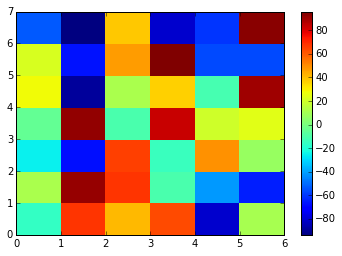

In [14]:
zern_coefs0 = (2*np.random.rand(7,nZernCoefs)-1)*M1_init['bending modes [micron]']*1e-6
zern_coefs0[:,6:] = 0
pcolor(zern_coefs0*1e9)
colorbar()
print nZernCoefs

### M2 x,y and z translations

In [15]:
com2xyz0 = np.zeros((7,3))
com2xyz0[:,0] = (2*np.random.rand(7)-1)*M2_init["Tx [micron]"]*1e-6
com2xyz0[:,1] = (2*np.random.rand(7)-1)*M2_init["Ty [micron]"]*1e-6
com2xyz0[:,2] = (2*np.random.rand(7)-1)*M2_init["Tz [micron]"]*1e-6
#com2xyz0 = (2*np.random.rand(21,1)-1)*50e-6
print array_str(com2xyz0*1e6,precision=2)
com2xyz0 = np.reshape(com2xyz0,(21,1))

[[-259.32   18.64  -13.38]
 [ 132.51 -220.09   13.76]
 [ 367.25  246.55   19.32]
 [  -2.09 -296.25  -24.57]
 [ -18.32  393.89    7.88]
 [-394.68  344.58  -14.05]
 [ 264.9  -146.07    3.13]]


### M2 segment tip-tilts

In [16]:
print M2_init['Rx [arcsec]']
com20 = np.reshape(com20,(7,2))
com20[:,0] = (2*np.random.rand(7)-1)*M2_init["Rx [arcsec]"]*ceo.constants.ARCSEC2RAD
com20[:,1] = (2*np.random.rand(7)-1)*M2_init["Ry [arcsec]"]*ceo.constants.ARCSEC2RAD
#com20[:,2] = (2*np.random.rand(7)-1)*M2_init["Rz [arcsec]"]*ceo.constants.ARCSEC2RAD
print array_str(com20*ceo.constants.RAD2MAS,precision=2)
com20 = np.reshape(com20,(14,1))

7.2
[[-5890.9   4829.69]
 [  654.81  -180.25]
 [-6561.44 -2206.03]
 [ 4070.41 -2410.76]
 [-4246.25 -1440.94]
 [-5563.9   -160.81]
 [-4620.17  6326.12]]


### Noise condition

In [17]:
ron = 0
gs.magnitude = AGWS_magnitude
print gs.nPhoton*30*368

3.60014377334e+16


## Initial on-axis PSF and wavefront

In [18]:
from IPython.display import display, clear_output


gmt.reset()
gmt.M1.global_tiptilt(com10[0],com10[1])
#com1[23:] = np.random.randn(14,1)*1e-7
gmt.M1.zernike.a[:,zmodes] = zern_coefs0
gmt.M1.zernike.update()
com2 = np.array( com20 )

M1_O_GT = gmt.M1.motion_CS.origin
M1_A_GT = gmt.M1.motion_CS.euler_angles
M1_A_GT[:,:2] += M1_STT
for k in range(7):
    gmt.M1.update(origin=[M1_O_GT[k,0],M1_O_GT[k,1],M1_O_GT[k,2]],
                  euler_angles=[M1_A_GT[k,0],M1_A_GT[k,1],M1_A_GT[k,2]],idx=k+1)
    gmt.M2.update(origin=[com2xyz0[3*k],com2xyz0[3*k+1],com2xyz0[3*k+2]],
                  euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

Initial WFE rms: 363530.27nm


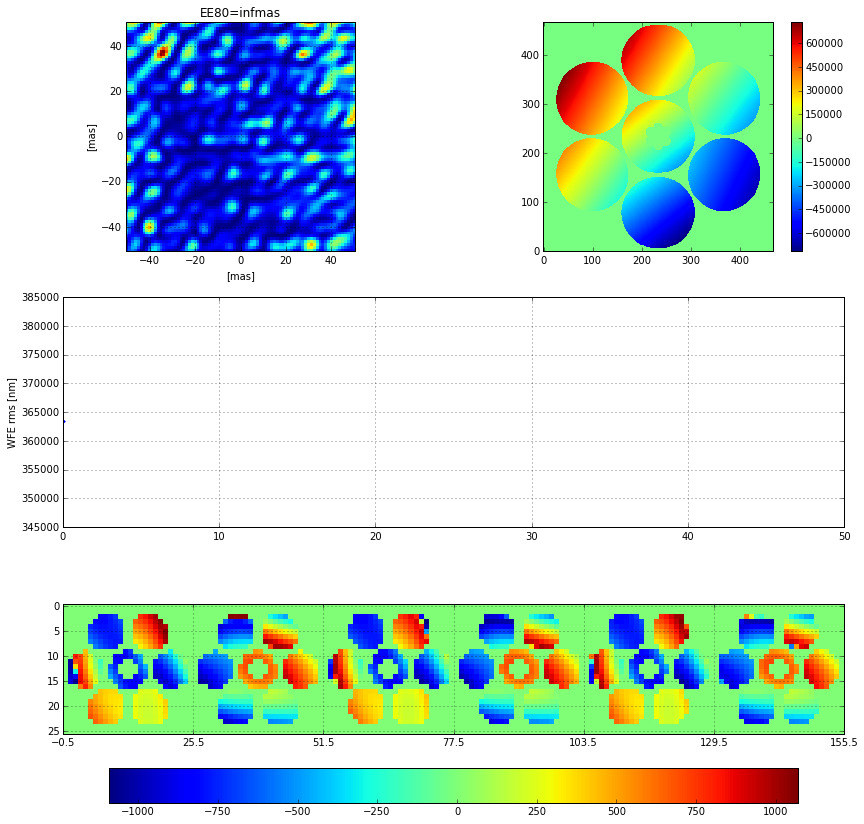

In [19]:
gs.reset()
wfs.reset()

src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)

fig = figure()
fig.set_size_inches((14,14))
ax1 = plt.subplot2grid((3,2),(0,0))
ax2 = plt.subplot2grid((3,2),(0,1))
ax3  = plt.subplot2grid((3,2),(1,0), colspan=2)
ax4 = plt.subplot2grid((3,2),(2,0), colspan=2)

psf = imgr.frame.host()

h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ax1.set_title("EE80=%.2fmas"%ee80(psf,px_scale))

h2 = ax2.imshow(src.phase.host(units='nm'),interpolation='none',origin='lower')
colorbar(h2,ax=ax2)

gmt.propagate(gs)
wfs.propagate(gs)
wfs.readOut(30,ron)
wfs.process()

n1Step = 50
wfe_rms = np.zeros(n1Step+1)
wfe_rms[0] = src.wavefront.rms(-9)
h3, = ax3.plot(wfe_rms[:1],'.-')
ax3.grid()
ax3.set_ylabel("WFE rms [nm]")
ax3.set_xlim((0,n1Step))
ax3.set_autoscaley_on(True)
print "Initial WFE rms: %6.2fnm"%wfe_rms[0]

c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
h4 = ax4.imshow(c,interpolation='none')
colorbar(h4,ax=ax4,orientation='horizontal')
h4.set_label("[mas]")
ax4.set_xticks(np.arange(0,N_LENSLET*(2*gs.N_SRC+1),N_LENSLET)-0.5)
ax4.grid()

## Stacking images

In [20]:
com2xyz = com2xyz0
M2tt7 = np.linalg.pinv(D2tt7)
nStep = 20
M2_R = np.zeros((14,nStep))
M2_R[:,0] = com20.ravel()
a23 = np.zeros((14,gs.size,nStep-1))
com2 = np.zeros((14,1))

In [ ]:
gs.reset()
gmt.propagate(gs)
print np.dot(M2tt7,np.ravel(sts.tiptilt(gs) - a230))*ceo.constants.RAD2MAS
for kStep in range(nStep-1):
    gs.reset()
    gmt.propagate(gs)
    a23[:,:,kStep] = sts.tiptilt(gs) - a230
    com2 -= 0.5*np.dot(M2tt7,a23[:,:,kStep].ravel()).reshape(-1,1)
#    print M2_R/mas2rad
#    print M2_R.shape
    for k in range(7):
        R = [ com2[2*k], com2[2*k+1], 0]
        gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],0*com2xyz[3*k+2]],
                      euler_angles=R,idx=k+1)

In [ ]:
fig_, axs = plt.subplots(ncols=4)
fig_.set_size_inches(16,4)
h11=axs[0].stem(com2*ceo.constants.RAD2ARCSEC)
for k in range(1,gs.size+1):
    hs=axs[k].plot(a23[:,k-1,:].T*1e6)
    axs[k].grid()
print com2.T*ceo.constants.RAD2MAS

## Closing the loop

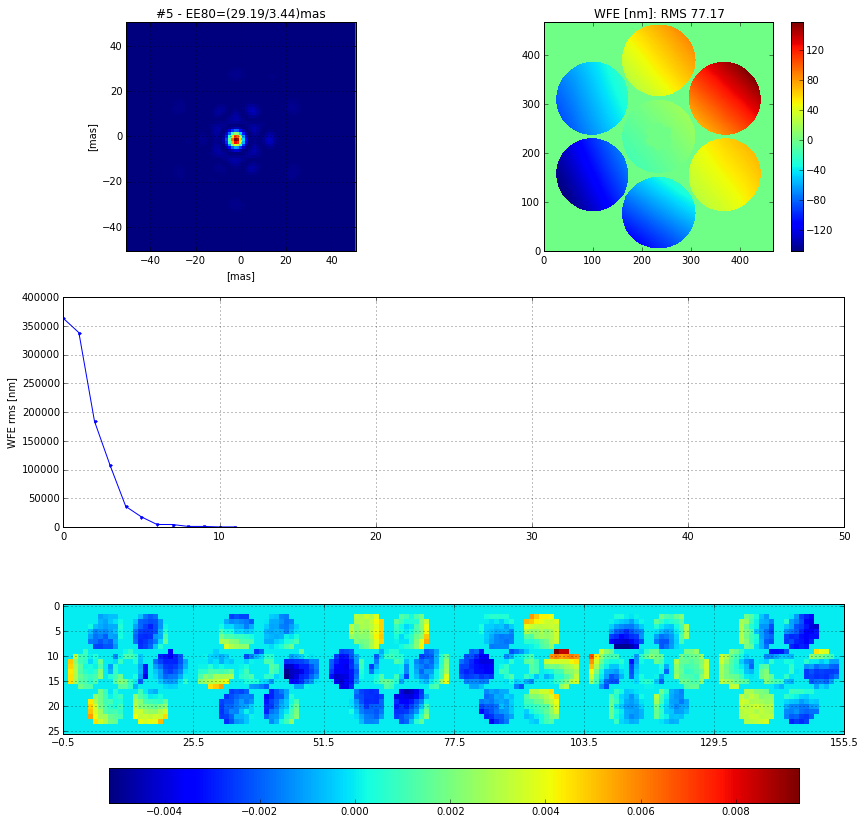

In [ ]:
import time
from ceo.constants import ARCSEC2RAD, MAS2RAD
M1_gtt_int = np.zeros((2,1))
M1_gtt = com10[:2]
com2xyz = com2xyz0
M1_stt = M1_STT
k1Step = 0
idx = 0
closed_loop = True
#while closed_loop:
for k1Step in range(20):
    
    #%run GMT-DOS-Estimation-SAO.py
    
    #ron = read_out_noise
    #gs.magnitude = AGWS_magnitude
    
    gs.reset()
    gmt.propagate(gs)
    com2 -= np.dot(M2tt7,np.ravel(sts.tiptilt(gs) - a230)).reshape(-1,1)

    for k2Step in range(5):
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        #wfs.analyze(gs)
        wfs.propagate(gs)
        wfs.readOut(30,ron)
        wfs.process()
        com2 -= np.dot(M2,wfs.valid_slopes.host().T)
        for k in range(7):
            gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                          euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)
    
    
    src.reset()
    gmt.propagate(src)

    wfe = src.phase.host(units='nm')
    idx += 1
    idx = idx%(n1Step+1)
    wfe_rms[idx] = 1e9*src.wavefront.rms()
    
            
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.propagate(gs)
    wfs.readOut(30,ron)
    wfs.process()
    #wfs.analyze(gs)
    
    com1_est = np.dot(M12,wfs.valid_slopes.host().T)
    gmt.M1.global_tiptilt(com1_est[0],com1_est[1])
    _M1_O_GT_ = gmt.M1.motion_CS.origin
    _M1_A_GT_ = gmt.M1.motion_CS.euler_angles
    
#    M1_gtt = M1_gtt - g1*com1_est[:2]
    M1_O_GT = M1_O_GT - g1*_M1_O_GT_
    M1_A_GT = M1_A_GT - g1*_M1_A_GT_

    
    com2xyz = com2xyz - g1*com1_est[2:23]
    
    if com1_est.size>23:
        gmt.M1.zernike.a[:,zmodes] -=  g1*com1_est[23:].reshape(7,-1)
        gmt.M1.zernike.update()
    
    #M1_stt = M1_stt - g1*com1_est[2:16].reshape(7,-1)
    #M1_A_GT[:,:2] += M1_stt

    for k in range(7):
        gmt.M1.update(origin=[M1_O_GT[k,0],M1_O_GT[k,1],M1_O_GT[k,2]],
                  euler_angles=[M1_A_GT[k,0],M1_A_GT[k,1],M1_A_GT[k,2]],idx=k+1)
        gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                     euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)
    
    src.reset()
    gmt.propagate(src)
    imgr.reset()
    imgr.propagate(src)

    wfe = src.phase.host(units='nm')
    idx += 1
    idx = idx%(n1Step+1)
    wfe_rms[idx] = 1e9*src.wavefront.rms()
    
    ax3.relim()
    ax3.autoscale_view(scaley=True)
    
    if k1Step<n1Step:
        h3.set_data(arange(idx),wfe_rms[:idx])
    else:
        h3.set_data(arange(n1Step+1),np.roll(wfe_rms,-idx-1))
    
    psf = imgr.frame.host()
    src.reset()
    gmt.propagate(src,where_to="focal plane")
    h1.set_data(psf)
    h1.set_clim((psf.min(),psf.max()))
    ax1.set_title("#%d - EE80=(%.2f/%.2f)mas"%(k1Step,ee80(psf,px_scale),src.rays.ee80('square')*ceo.constants.RAD2MAS))

    h2.set_data(wfe)
    h2.set_clim((wfe.min(),wfe.max()))
    ax2.set_title( "WFE [nm]: RMS %4.2f"%wfe_rms[idx])
        
    c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
    h4.set_data(c)
    h4.set_clim((c.min(),c.max()))

#    time.sleep(3)
    
    
    clear_output(wait=True)
    display(fig)
plt.close()

In [26]:
print wfe_rms[:]

[ 84285.47880612    551.43798828    551.43798828    551.43798828
    551.43798828    551.43798828    551.43798828    551.43798828
    551.43798828    551.43792725    551.43792725    551.43798828
    551.43798828    551.43798828    551.43798828    551.43798828
    551.43798828    551.43798828    551.43798828    551.43792725
    551.43792725    551.43798828    551.43798828    551.43798828
    551.43798828    551.43798828    551.43798828    551.43798828
    551.43798828    551.43798828    551.43798828    551.43798828
    551.43798828    551.43798828    551.43798828    551.43798828
    551.43798828    551.43798828    551.43798828    551.43798828
    551.43798828      0.              0.              0.              0.
      0.              0.              0.              0.              0.
      0.        ]


In [ ]:
print "M1 global tip-tilt [mas]:"
print M1_gtt*ceo.constants.RAD2MAS
print "M1 Tx, Ty and Tz [micron]:"
print np.array_str(M1_O_GT.reshape(7,3)*1e6,precision=3,suppress_small=True)
print "M1 Rx and Ry [micron]:"
print np.array_str(M1_A_GT.reshape(7,3)*1e6,precision=3,suppress_small=True)
print "M2 Tx, Ty and Tz [nm]:"
print np.array_str(com2xyz.reshape(7,3)*1e9,precision=3,suppress_small=True)
print "M2 Rx and Ry [mas]:"
print np.array_str(com2.reshape(7,2)*ceo.constants.RAD2MAS,precision=3,suppress_small=True)

In [ ]:
M1_O_GT = gmt.M1.motion_CS.origin
M1_A_GT = gmt.M1.motion_CS.euler_angles
print M1_A_GT*ceo.constants.RAD2MAS

In [ ]:
print "M2 Rx and Ry [mas]:"
print np.array_str(np.dot(M2,wfs.valid_slopes.host().ravel())*ceo.constants.RAD2MAS,precision=3,suppress_small=True)
M1gtt_2 = pinv(D1gtt_2)
M2xyz_2 = pinv(D2xyz_2)
M1z_2   = pinv(D1z_2)
coms = np.dot(M12,wfs.valid_slopes.host().T)
print coms.shape
print "M1 global tip-tilt [mas]:"
print np.array_str(coms[:2].ravel()*ceo.constants.RAD2MAS,precision=3,suppress_small=True)
print "R2 Rx and Ry [mas]:"
print np.array_str(coms[:].ravel()*ceo.constants.RAD2MAS,precision=3,suppress_small=True)
M1_stt = M1_stt - g1*coms.reshape(7,-1)
print np.array_str(M1_stt.ravel()*ceo.constants.RAD2MAS,precision=3,suppress_small=True)
print "M2 Tx, Ty and Tz [nm]:"
print np.array_str(coms[:].ravel()*1e9,precision=3,suppress_small=True)
print "M1 Zernike [nm]:"
print np.array_str(coms[:].ravel()*1e9,precision=3,suppress_small=True)

In [ ]:
gmt.M1.global_tiptilt(coms[0],coms[1])

In [ ]:
U,S,V = svd(np.concatenate((D1gtt_2,D2xyz_2),axis=1),full_matrices=False)
semilogy(S,'.')
grid()
iS = 1.0/S
iS[-2:]=0
M = np.dot(V,np.dot(np.diag(iS),U.T))

In [ ]:
print coms[:2]*ceo.constants.RAD2MAS

In [ ]:
print coms[:23]*1e9

In [ ]:
print coms[23:]*1e9

## Wavefront error rms

In [ ]:
plot(wfe_rms[:20],'.-')
grid()
xlabel('Steps')
ylabel('WFE [nm]')
print wfe_rms[0]

In [ ]:
wfe_rms[0:20]

In [ ]:
wfs.reset()
wfs.analyze(gs)
fig_c = figure()
fig_c.set_size_inches((12,8))
imshow(wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(orientation='horizontal')

In [ ]:
P = src.rays.piston_mask
print P[0].shape
imshow(np.reshape(P[0][0,:],(nPx,nPx)))
print P[0].sum(axis=1)
print gs.wavefront.amplitude.host()[0,:].sum()
src.size

In [ ]:
P1 = P[0]
P1 = np.rollaxis(np.array(P),0,3)
src.rays.
u = arange(nPx)
x,y = meshgrid(u,u)
x = x.reshape(1,-1,1)
y = y.reshape(1,-1,1)
xc = np.sum(x*P1,axis=1)/P1.sum(axis=1)
yc = np.sum(y*P1,axis=1)/P1.sum(axis=1)
print xc
print yc

In [ ]:
fig,ax0 = subplots()
#ax0.imshow(np.reshape(P[0][0,:],(nPx,nPx)))
ax0.scatter(xc,yc)


In [ ]:
x.shape

In [ ]:
yc_ = yc.reshape(7,1,3)
print yc

In [ ]:
imshow(y.reshape(nPx,nPx)-yc[0,0])
colorbar()

In [ ]:
P1.shape

In [ ]:
yc_[:,0,1]

In [ ]:
Z2 = (x - xc.reshape(7,1,3))*P1
Z3 = (y - yc.reshape(7,1,3))*P1

In [ ]:
print Z2.shape

In [ ]:
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
h1 = ax1.imshow(np.reshape(Z2[:,:,1].sum(axis=0),(nPx,nPx)))
colorbar(h1,ax=ax1)
h2 = ax2.imshow(np.reshape(Z3[:,:,2].sum(axis=0),(nPx,nPx)))
colorbar(h2,ax=ax2)

In [ ]:
W = np.rollaxis( gs.wavefront.phase.host(shape=(1,3,nPx*nPx)), 1, 3)
W.shape

In [ ]:
imshow(np.reshape(W[0,:,0],(nPx,nPx)))

In [ ]:
a2 = np.sum(W*Z2,axis=1)/np.sum(Z2*Z2,axis=1)

In [ ]:
a3 = np.sum(W*Z3,axis=1)/np.sum(Z3*Z3,axis=1)

In [ ]:
gs.reset()

In [ ]:
a2.shape